## Unit 1, Lesson 3.6 Data Cleaning ##

1. Determine the five most common journals and the total articles for each.
2. Next, calculate the mean, median, and standard deviation of the open-access cost per article for each journal.
3. BONUS: Identify the open access prices paid by subject area.

First, let's set up the data and take a look at the file.

In [32]:
#preamble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
%matplotlib inline
import re
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Read in the data, using iso-8859-1 encoding
wellcome = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/wellcome.csv', encoding='iso-8859-1')
wellcome_clean = wellcome
wellcome_clean.columns = ['PMID/PMCID', 'Publisher', 'Journal title', 'Article title','Cost']
wellcome_clean.head()

,PMID/PMCID,Publisher,Journal title,Article title,Cost
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


The first step is to clean the journal titles. We will start by casting them all in title case and stripping trailing white space. Next, let's examine how many times each title occurs, to make it easier to identify errors in those that occur only once.

In [33]:
#Use title case for the journal title field.
#Strip trailing whitespace.
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).title())
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).strip())

#Count how often the title occurs.
#Caveat: Some of the 'dirty' titles occur more than once. 

wellcome_clean['freq'] = wellcome_clean.groupby('Journal title')['Journal title'].transform('count')
wellcome_clean['freq'] = wellcome_clean['freq'].sort_values()
len(wellcome_clean[wellcome_clean['freq']==1])

571

Since 571 of the titles occur only once, this may not be the most efficient way to identify errors. Based on a few cursory observations, let's proceed by replacing strings for more consistent use of abbreviations.

In [34]:
#Clean inconsistent journal names by removing 'the' and spelling out abbreviations.
#NOTE: More cleaning needed.
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('J ', 'Journal of '))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('The Journal', 'Journal'))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('Org ', 'Organic '))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('Med ', 'Medicinal '))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('Psychiatty', 'Psychiatry'))

#NOTE: How can I get a regex to work inside str.replace? So far, no luck.

#wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('Birth Defects Research', 'Birth Defects Research'))

Now that the journal titles are (more or less) clean, we will move onto the price column. The data in the price column is currently strings, but we need it to be numeric in order to maniupate it. There are currency symbols before and after the numerican information, which should be moved to a separate column.

In [35]:
#Now let's clean the Price column.
#Use a regex to assign the numerical information, including decimal point, to its own column.
wellcome_clean['Price'] = wellcome_clean['Cost'].str.findall(r'\d+[.]\d+')
wellcome_clean['Price'] = wellcome_clean['Price'].apply(lambda x: x[0] if x else 0)
wellcome_clean['Price'] = wellcome_clean['Price'].apply(lambda x: pd.to_numeric(x))
wellcome_clean['Price'].head()

0       0.00
1    2381.04
2     642.56
3     669.64
4     685.88
Name: Price, dtype: float64

In [36]:
#Use a regex to assign currency symbols to their own column.
#Caveat: For now, Price does not have any currency conversion, 
#so the values should not really be compared.

wellcome_clean['Currency'] = wellcome_clean['Cost'].str.findall(r'$')
wellcome_clean['Currency'] = wellcome_clean['Cost'].str.findall(r'£')

We will use a histogram to get a sense for the distribution of the price information.

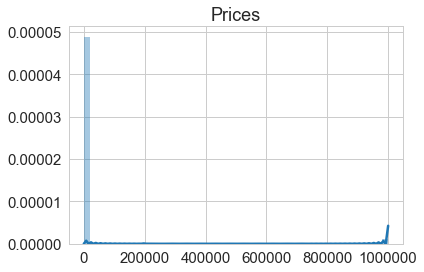

In [37]:
#Check Price for anomalous values.
ax = sns.distplot(wellcome_clean['Price'])
ax.set(xlabel='', ylabel='', title='Prices')
plt.show()

Several articles are priced at 999999.00. 999999 is most likely a missingness indicator, since there is no currency symbol and this is an implausible value for a journal article. Let us replace 999999.00 with NaN, and then impute the price by substituting the mean article price for the appropriate journal. 

In [38]:
#NOTE: means are showing up as NaN; 
#also tried including the calculation as the argument of .fillna(), to no avail.
#Not sure what is wrong here.
wellcome_clean[wellcome_clean['Price'] == 999999.00] = None
means = wellcome.groupby(['Journal title'])['Price'].mean()
wellcome_clean['Price'] = wellcome_clean['Price'].fillna(means)

#df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
#df.fillna(df.mean(),inplace=True)
#wellcome_clean['Price'] = wellcome_clean['Price'].fillna(wellcome_clean['Price'].groupby(wellcome_clean['Journal title']).mean())

Now that we have dealt with the incorrectly coded missing prices, let's take a look at other potentially incorrect values. We will examine the high outliers that are in the top 1% of the dataset. We will find some high outliers with implausible values, and take a closer look at the highest one to identify the source of the problem. 

In [39]:
#Recheck distribution.
outliers = wellcome_clean[wellcome_clean['Price'] > wellcome_clean['Price'].quantile(.99)]
print(outliers)

                             PMID/PMCID                  Publisher  \
490                          PMC3650559                   Elsevier   
526                                 NaN                   Elsevier   
542                             3605578                   Elsevier   
552                 23541370 PMC3744751                   Elsevier   
648                                 NaN                   Elsevier   
668                   PMCID: PMC3594747                   Elsevier   
728                          PMC3748348                   Elsevier   
729                             2875410                   Elsevier   
786                   PMCID: PMC3694306                   Elsevier   
796                          PMC3525981                   Elsevier   
797                                 NaN                   Elsevier   
798            PMCID:\r    PMC3627205\r                   Elsevier   
799                                 NaN                   Elsevier   
800   PMID: 23041239

The max value is \$201024.00. Other articles in the same journal are $2010.24, so the high value appears to be a decimal placement error. The decimal can be moved to correct the value, and the remaining outliers rechecked for similar anomalies, correcting as necessary.

In [40]:
wellcome_clean['Price'].replace(201024.00, 2010.24, inplace=True)
wellcome_clean['Price'].replace(192645.00, 1926.45, inplace=True)
wellcome_clean['Price'].replace(13200.00, 1320.00, inplace=True)
wellcome_clean['Price'].replace(6000.00, 600.00, inplace=True)

Remaining high values appear to be legitimate, so we will not change them.

Now we are ready to answer the questions we started with. First, let's print the five most common journals and the number of articles for each. 

In [41]:
print(wellcome_clean['Journal title'].value_counts()[:5])

Plos One                           183
Journal Of Biological Chemistry     59
Neuroimage                          29
Nucleic Acids Research              26
Plos Pathogens                      22
Name: Journal title, dtype: int64


Next, we'll print the description for the price information to identify the mean, median, and standard deviation of prices per journal.

In [42]:
print(wellcome_clean['Price'].groupby(wellcome_clean['Journal title']).describe())

                                                    count         mean  \
Journal title                                                            
Academy Of Nutrition And Dietetics                    1.0  2379.540000   
Acs Chemical Biology                                  5.0  1418.186000   
Acs Chemical Neuroscience                             1.0  1186.800000   
Acs Nano                                              2.0   668.140000   
Acta Crystallographica Section D,  Biological C...    1.0   771.420000   
Acta Crystallographica Section D: Biological Cr...    1.0   773.740000   
Acta Crystallographica Section F: Structural Bi...    2.0   796.635000   
Acta Crystallographica, Section D                     1.0   757.180000   
Acta Crystallography D                                1.0   774.190000   
Acta D                                                1.0   750.160000   
Acta Dermato Venereologica                            1.0   653.960000   
Acta Diabetologica                    